# Position dependency

Compute the rms on the x and y positions for each lightcurve and look to see a trend on the chip.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import fitsio
import seaborn as sns
import sys
sys.path.insert(0, '..')
from binmodule import fast_bin
from astropy.stats import sigma_clip
from scipy.stats import binned_statistic_2d, spearmanr

sns.set(context='poster', rc={'figure.figsize': (16, 10)})
sns.set_palette('Paired', n_colors=12)
colours = sns.color_palette()

In [2]:
# Number of points to ignore from the beginning
SKIP = 20

In [3]:
with fitsio.FITS('../data/20150911-ng2000-802-custom-flat-high-quality.fits') as infile:
    flux = infile['casudet'][:, SKIP:]
    ccdx = infile['ccdx'][:, SKIP:]
    ccdy = infile['ccdy'][:, SKIP:]
    imagelist = infile['imagelist'].read()[SKIP:]

In [4]:
# Distance from pixel 0, 0
r = np.sqrt(ccdx ** 2 + ccdy ** 2)

In [5]:
rms_x, rms_y, _ = [np.std(data, axis=1) for data in [ccdx, ccdy, r]]
ptp_x, ptp_y, ptp_r = [np.ptp(data, axis=1) for data in [ccdx, ccdy, r]]
med_x, med_y, _ = [np.median(data, axis=1) for data in [ccdx, ccdy, r]]
rms_r = np.sqrt(rms_x ** 2 + rms_y ** 2)

We now plot the raw statistics to see what the ranges are.

''

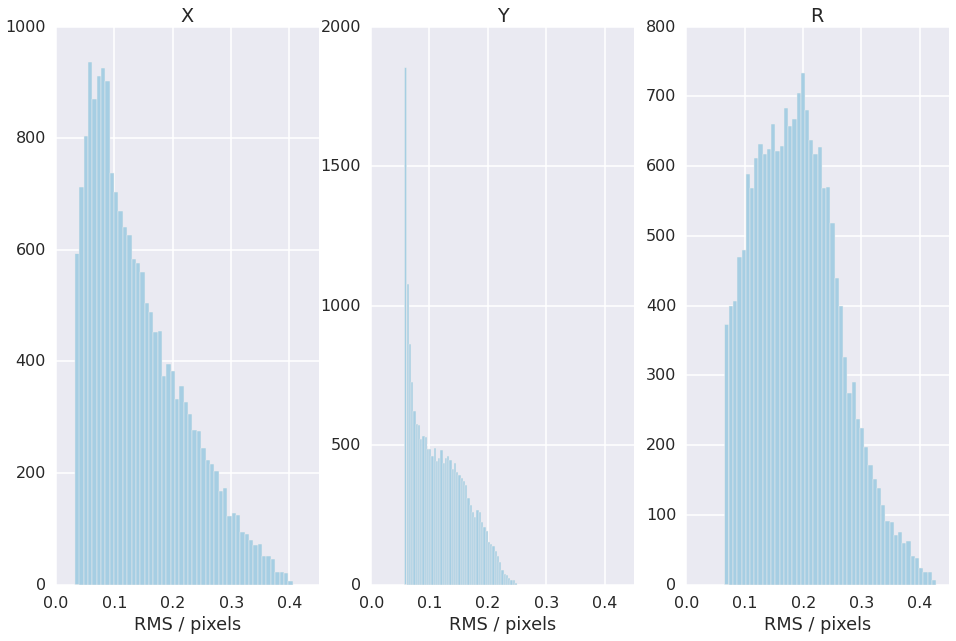

In [6]:
fig, axes = plt.subplots(1, 3, sharex=True)
axes[0].hist(rms_x, 50)
axes[1].hist(rms_y, 50)
axes[2].hist(rms_r, 50)
axes[0].set(title='X')
axes[1].set(title='Y')
axes[2].set(title='R')

locator = plt.MultipleLocator(0.1)
for ax in axes:
    ax.set(xlabel='RMS / pixels')
    ax.xaxis.set_major_locator(locator)

;

Note these are RMS calculations rather than the peak to peak estimate. The peak to peak is likely sensitive to outliers, which may mask any trends. Also the total shift is dominated by the X direction, which is the RA axis.

## Spatial dependance

''

/home/sw/work/NGTS/lightcurve-visualiser/venv/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


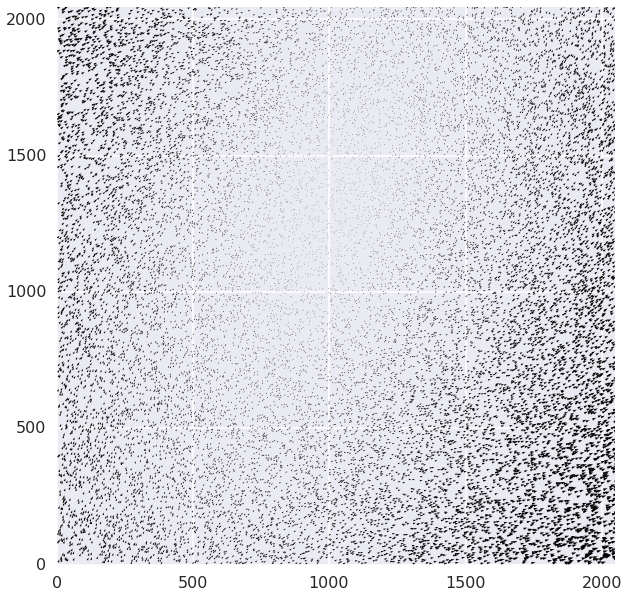

In [7]:
fig, axis = plt.subplots()
Q = axis.quiver(med_x, med_y, rms_x, rms_y, minlength=0.)
axis.set(xlim=(0, 2047), ylim=(0, 2047), aspect='equal')
;

Clearly there is a spatial dependance here. Strangely the centre is slightly up and two the right in the chip. What is the astrometric reference pixel doing?

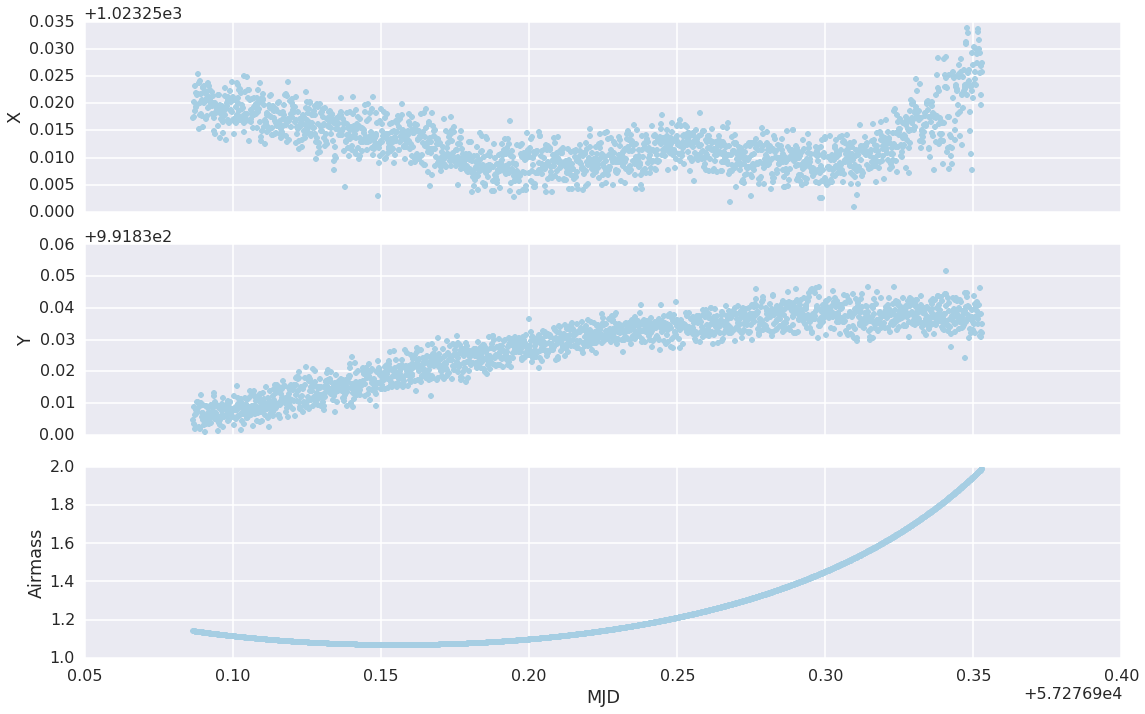

In [8]:
fig, axes = plt.subplots(3, 1, sharex=True)
axes[0].plot(imagelist['TMID'], imagelist['CRPIX1'], '.')
axes[1].plot(imagelist['TMID'], imagelist['CRPIX2'], '.')
axes[2].plot(imagelist['TMID'], imagelist['AIRMASS'], '.')
axes[0].set(ylabel='X')
axes[1].set(ylabel='Y')
axes[2].set(ylabel='Airmass')
axes[-1].set(xlabel='MJD')
fig.tight_layout()

Because the reference pixel shifts, compute the median central position and overlay on the quiver plot.

''

/home/sw/work/NGTS/lightcurve-visualiser/venv/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


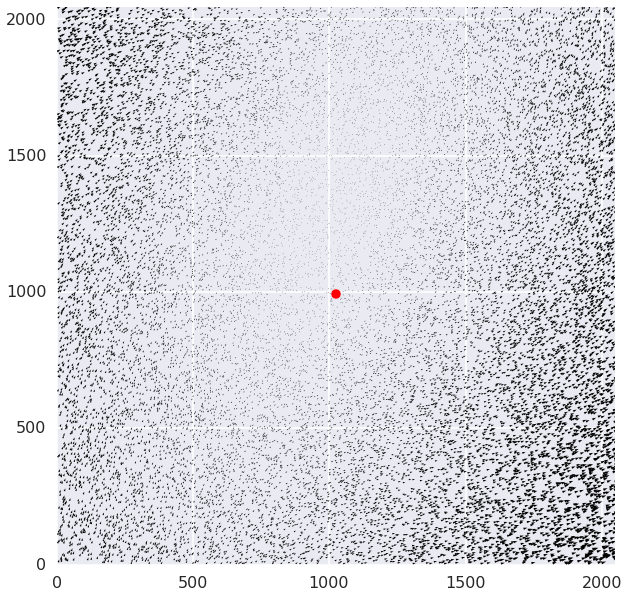

In [9]:
fig, axis = plt.subplots()
Q = axis.quiver(med_x, med_y, rms_x, rms_y, minlength=0.)
axis.set(xlim=(0, 2047), ylim=(0, 2047), aspect='equal')
axis.scatter(np.median(imagelist['CRPIX1']), np.median(imagelist['CRPIX2']), c='r', s=100)
;

With larger arrows:

''

/home/sw/work/NGTS/lightcurve-visualiser/venv/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


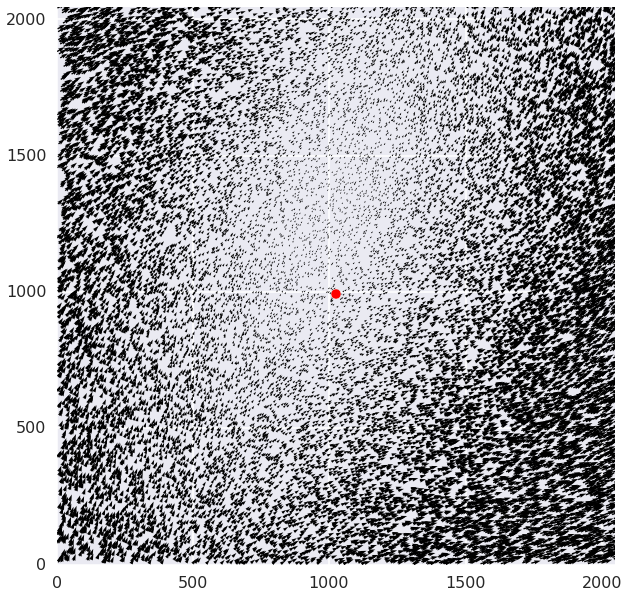

In [10]:
fig, axis = plt.subplots()
Q = axis.quiver(med_x, med_y, rms_x, rms_y, minlength=0., scale_units='xy', scale=0.01)
axis.set(xlim=(0, 2047), ylim=(0, 2047), aspect='equal')
axis.scatter(np.median(imagelist['CRPIX1']), np.median(imagelist['CRPIX2']), c='r', s=100)
;

This is in the low rms region, but certainly not at its centre. From the histograms above, the bulk shift is in the X axis. Stars in the bottom right are shifting right, as are the stars in the top left. The reference pixel is moving upwards constantly, but it is not clear that it is moving rightwards - it is a little hard to tell.

Can we find the centre of the shift?

In [11]:
def sigma_clip_average(data):
    sc = sigma_clip(data)
    return np.average(sc)

(960.0, 1280.0)


/home/sw/work/NGTS/lightcurve-visualiser/venv/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


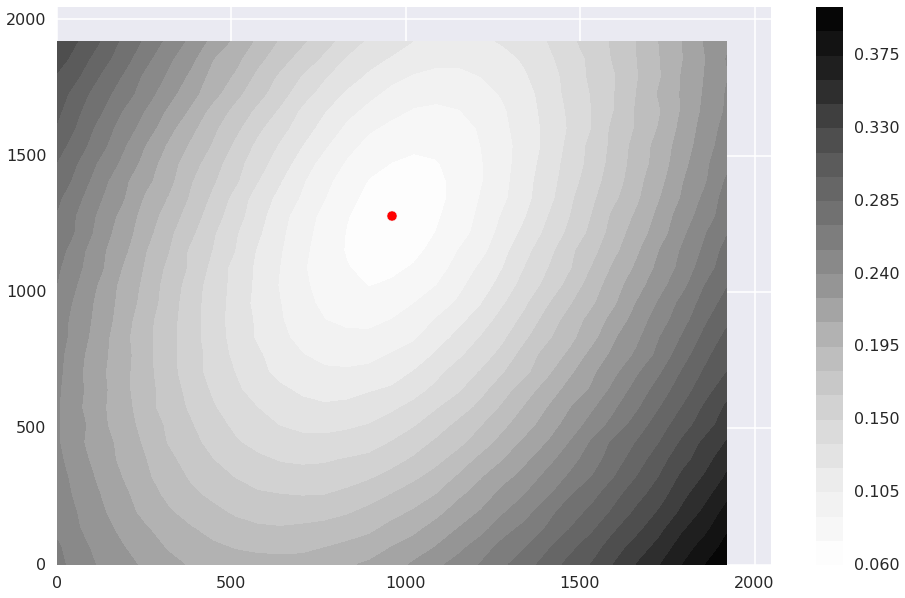

In [65]:
bins = np.linspace(0, 2048, 33)[:-1]
binned_rms, _, _, _ = binned_statistic_2d(
    med_x, med_y, rms_r, bins=[bins, bins], statistic=sigma_clip_average)
best_ind = np.where(binned_rms == binned_rms.min())

least_movement_position = (
    bins[best_ind[0][0]],
    bins[best_ind[1][0]],
)

plt.contourf(bins[:-1], bins[:-1], np.ma.masked_invalid(binned_rms.T), 25)
plt.colorbar()
plt.scatter(least_movement_position[0], least_movement_position[1], c='r', s=100)
plt.xlim(0, 2047)
plt.ylim(0, 2047)
print(least_movement_position)

## Affect on the photometry

Take a narrow strip in the frms diagram, and look at the frms as a function of position on the chip. First pick a suitable binning value to test with.

In [66]:
def mad_of_array(data, precomputed_median=None):
    med = precomputed_median if precomputed_median is not None else np.median(data, axis=1)
    return np.median(np.abs(data - med[:, np.newaxis]), axis=1)

In [67]:
def compute_frms(arr, sigma=None, ind=None):
    if sigma is not None:
        arr = sigma_clip(arr, sig=sigma, axis=1)
    
    if ind is None:
        ind = np.all(np.isfinite(arr), axis=1)
        
    med_flux = np.median(arr[ind], axis=1)
    mad_flux = mad_of_array(arr[ind], precomputed_median=med_flux)
    frms = 1.48 * mad_flux / med_flux
    return med_flux, frms, ind

In [68]:
def mad(data, precomputed_median=None):
    median = precomputed_median if precomputed_median is not None else np.median(data)
    return np.median(np.abs(data - median))

In [69]:
def plot_binned_frms(flux, points_per_bin, axis, left_edges=None, right_edges=None, **kwargs):
    binned_flux = fast_bin(flux, points_per_bin)
    
    ind = np.all(np.isfinite(binned_flux), axis=1)
    med_unbinned_flux = np.median(flux[ind], axis=1)
    selected_binned_flux = binned_flux[ind]
    
    med_flux, frms, _ = compute_frms(selected_binned_flux)
    axis.loglog(med_flux, frms, '.', **kwargs)
    
    x, y, e = [], [], []
    if left_edges is not None and right_edges is not None:
        for (l, r) in zip(left_edges, right_edges):
            x.append(10 ** ((np.log10(l) + np.log10(r)) / 2.))
            bin_ind = (med_unbinned_flux >= l) & (med_unbinned_flux < r)
            subset = selected_binned_flux[bin_ind]
            
            med_subset, frms_subset, _ = compute_frms(subset)

            sc_frms_subset = sigma_clip(frms_subset)
            y.append(np.median(sc_frms_subset))
            e.append(1.48 * mad(sc_frms_subset) / np.sqrt(sc_frms_subset.data[~sc_frms_subset.mask].size))
            
    axis.errorbar(x, y, e, ls='None', marker='.', capsize=0.)
    
    return [np.array(data) for data in [x, y, e]]

In [70]:
bin_values = np.unique(np.logspace(0, 2, 9).astype(int))

/home/sw/work/NGTS/lightcurve-visualiser/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:3151: RuntimeWarning: Invalid value encountered in median for 1 results
  RuntimeWarning)
/home/sw/work/NGTS/lightcurve-visualiser/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:3151: RuntimeWarning: Invalid value encountered in median for 2 results
  RuntimeWarning)
/home/sw/work/NGTS/lightcurve-visualiser/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:3151: RuntimeWarning: Invalid value encountered in median for 23 results
  RuntimeWarning)
/home/sw/work/NGTS/lightcurve-visualiser/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:3151: RuntimeWarning: Invalid value encountered in median for 26 results
  RuntimeWarning)
/home/sw/work/NGTS/lightcurve-visualiser/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:3151: RuntimeWarning: Invalid value encountered in median for 22 results
  RuntimeWarning)


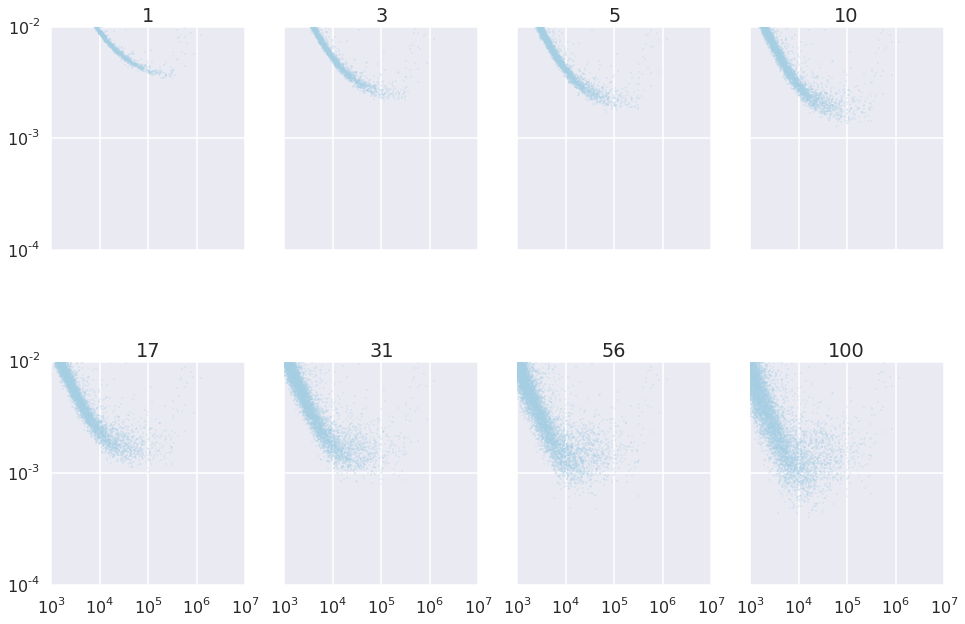

In [71]:
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True)

for (bin_value, ax) in zip(bin_values, axes.flatten()):
    plot_binned_frms(flux, bin_value, ax, ms=2)
    ax.set(title=bin_value, xlim=(1E3, 1E7), ylim=(1E-4, 1E-2))

Interestingly the stars above about 5E4 get stuck, whereas the stars around 1E4 don't. Let's overlay the binned noise values

In [72]:
left_edges = 10 ** np.linspace(2, 5, 10)[:-1]
right_edges = 10 ** (np.log10(left_edges) + 3. / 9.)

/home/sw/work/NGTS/lightcurve-visualiser/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:3151: RuntimeWarning: Invalid value encountered in median for 1 results
  RuntimeWarning)
/home/sw/work/NGTS/lightcurve-visualiser/venv/lib/python3.5/site-packages/numpy/ma/core.py:4085: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")
/home/sw/work/NGTS/lightcurve-visualiser/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:3151: RuntimeWarning: Invalid value encountered in median for 2 results
  RuntimeWarning)
/home/sw/work/NGTS/lightcurve-visualiser/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:3151: RuntimeWarning: Invalid value encountered in median for 23 results
  RuntimeWarning)
/home/sw/work/NGTS/lightcurve-visualiser/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:3151: RuntimeWarning: Invalid value encountered in median for 26 results
  RuntimeWarning)
/home/sw/work/N

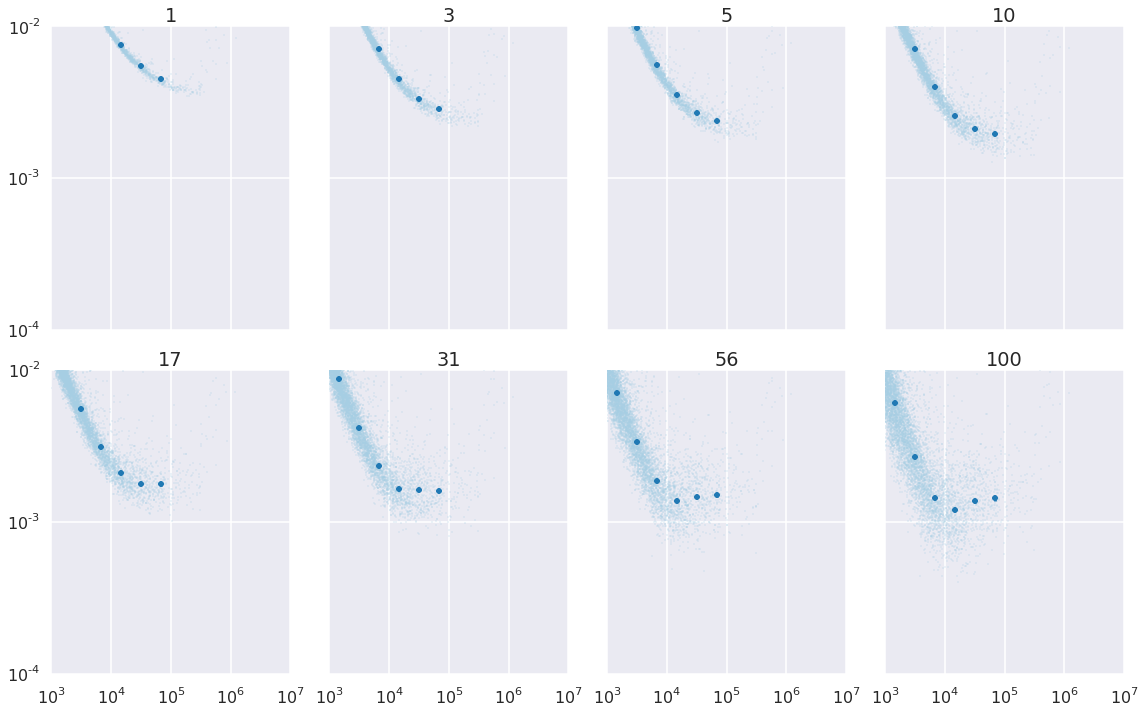

In [73]:
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True)

binned_stats = []
for (bin_value, ax) in zip(bin_values, axes.flatten()):
    x, y, e = plot_binned_frms(flux, bin_value, ax, left_edges=left_edges, right_edges=right_edges, ms=2)
    binned_stats.append((x, y, e))
    ax.set(title=bin_value, xlim=(1E3, 1E7), ylim=(1E-4, 1E-2))
fig.tight_layout()

In [74]:
binned_array = np.vstack([row[1] for row in binned_stats]).T
brightnesses = binned_stats[0][0]
binned_x = np.vstack([np.ones(binned_array.shape[0]) * v for v in bin_values]).T

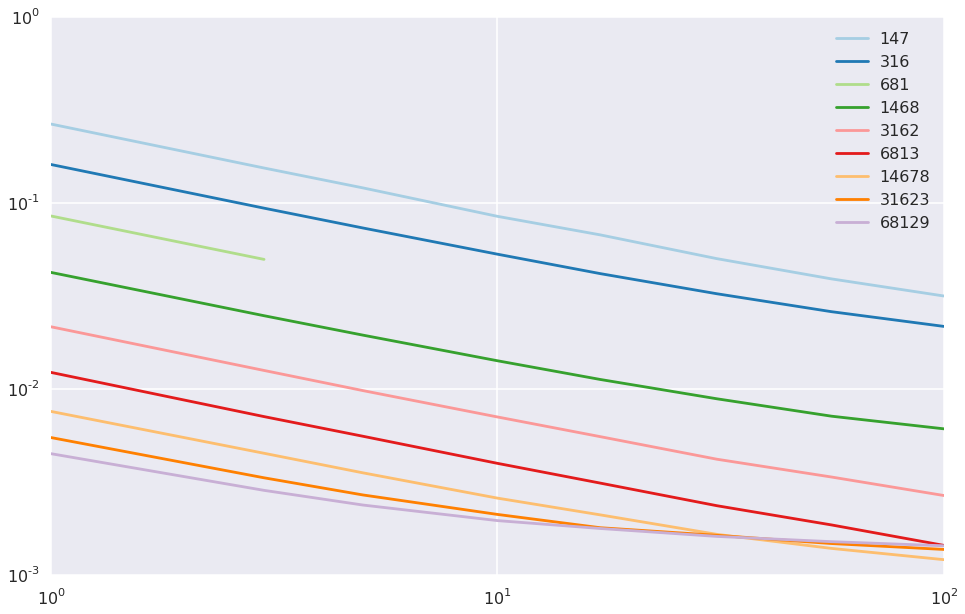

In [75]:
fig, axis = plt.subplots()
for (bx, by, brightness) in zip(binned_x, binned_array, brightnesses):
    axis.loglog(bx, by, label='{:.0f}'.format(brightness))
axis.legend(loc='best')

We pick the 1E4 to 2E4 range, and binning value 100.

In [76]:
bin_limits = (1E4, 2E4)
bin_value = 100

In [77]:
ind = np.all(np.isfinite(flux), axis=1)
valid_flux = flux[ind]
valid_ccdx, valid_ccdy = [data[ind] for data in [ccdx, ccdy]]
valid_med = np.median(valid_flux, axis=1)

In [78]:
chosen_ind = (valid_med >= bin_limits[0]) & (valid_med < bin_limits[1])
chosen_flux = valid_flux[chosen_ind]
chosen_ccdx, chosen_ccdy = [data[chosen_ind] for data in [valid_ccdx, valid_ccdy]]

In [79]:
binned_flux = fast_bin(chosen_flux, bin_value)
binned_med, binned_frms, ind = compute_frms(binned_flux, sigma=3.)
filtered_ccdx, filtered_ccdy = [data[ind] for data in [chosen_ccdx, chosen_ccdy]]
assert binned_frms.size == filtered_ccdx.shape[0] == filtered_ccdy.shape[0]

In [80]:
med_x, med_y = [np.median(data, axis=1) for data in [filtered_ccdx, filtered_ccdy]]

/home/sw/work/NGTS/lightcurve-visualiser/venv/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


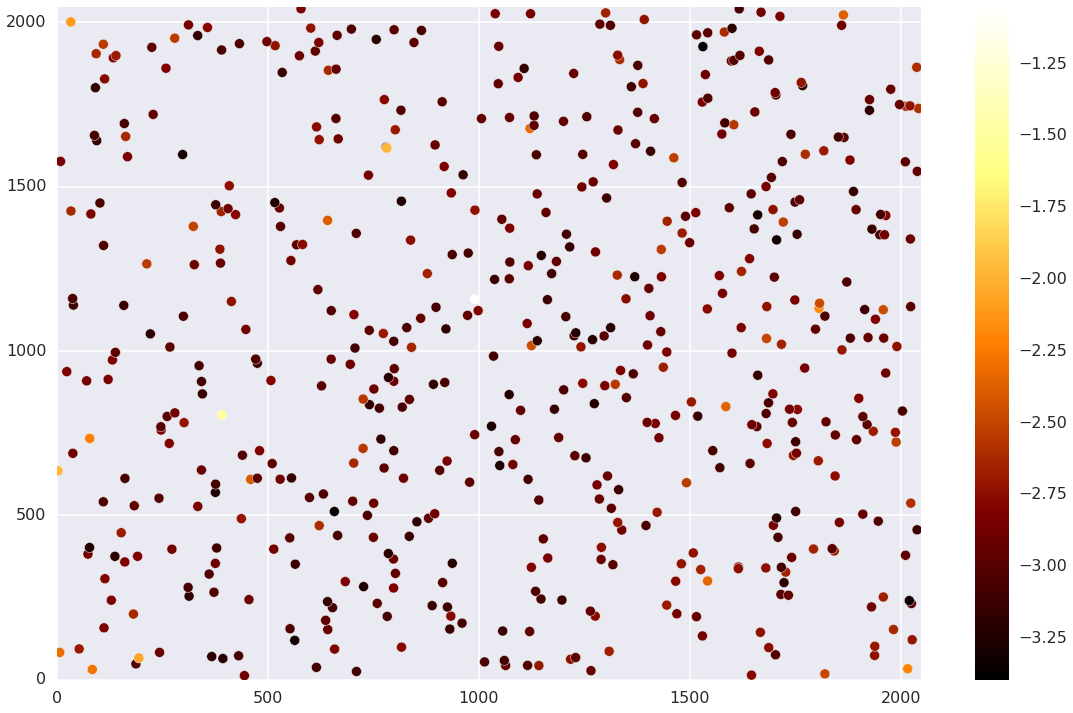

In [81]:
plt.scatter(med_x, med_y, c=np.log10(binned_frms), s=100, cmap='afmhot')
plt.colorbar()
plt.xlim(0, 2047)
plt.ylim(0, 2047)
plt.tight_layout()

In [82]:
r = np.sqrt((med_x - least_movement_position[0]) ** 2 + (med_y - least_movement_position[1]) ** 2)

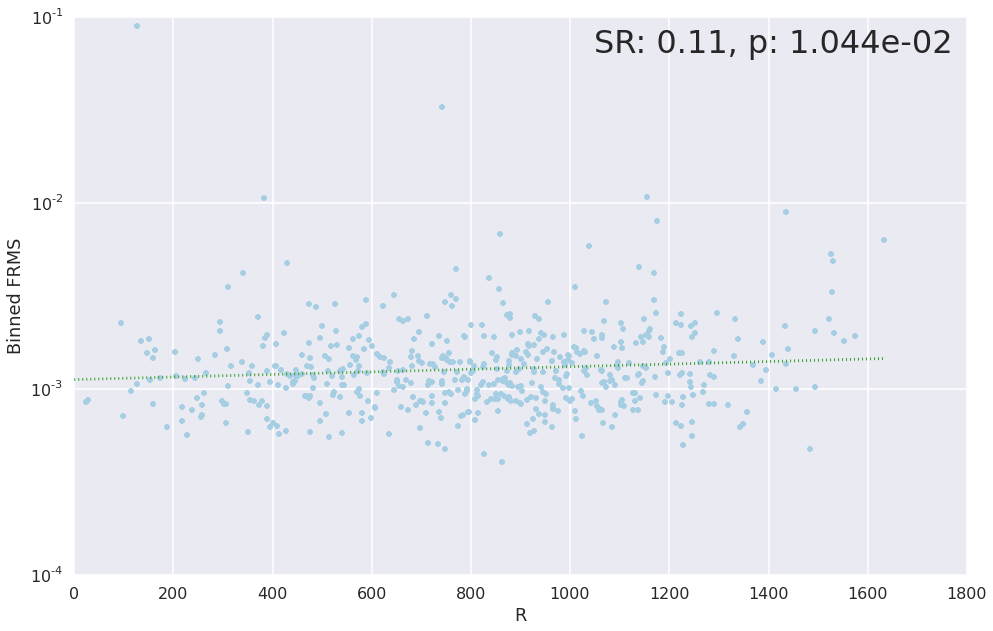

In [83]:
fig, axis = plt.subplots()
axis.semilogy(r, binned_frms, '.')
axis.set(xlabel='R', ylabel='Binned FRMS')
sr, p = spearmanr(r, np.log10(binned_frms))
axis.text(0.98, 0.98, 'SR: {:.2f}, p: {:.3e}'.format(sr, p),
          transform=axis.transAxes, ha='right', va='top', fontsize=32)
fit = np.poly1d(np.polyfit(r, np.log10(binned_frms), 1))
test_r = np.linspace(0, r.max(), 10)
axis.plot(test_r, 10 ** fit(test_r), ls=':', color=colours[3])

It looks like there is a correlation here. Therefore we need to be really hot on field rotation and chip movement.